In [1]:
#%%writefile sim_graph_funs.py
import numpy as np
import matplotlib.pyplot as plt
from fitness_funs_non_dim import *
from group_w_pop_funs import *
from scipy.optimize import fsolve

colors = ['k','r','b','cyan', 'magenta','orange',
         'gray', 'green']
markers = ["o","","v", ""]

def format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = False):
    ax.set_xlabel(xlab, fontsize = fs_labs)
    ax.set_ylabel(ylab, fontsize = fs_labs)
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    if if_legend:
        ax.legend(fontsize = fs_legend)
        
def get_results(out,x_max):
    '''
    gets results from output of simulation
    out: dictionary that's output of solve_ivp
    x_max: max group size

    @returns:
    T, N1, N2, P, mean_x
    '''
    P, N1, N2 = out2.y[0:3]
    F_of_x_vec = out2.y[3:]
    mean_x = mean_group_size_membership(F_of_x_vec.T, x_max, P)
    T = out2.t
    return T, N1, N2, P, F_of_x_vec, mean_x
def add_arrow(line, start_ind = None,  direction='right', size=15, color=None):
    """
    add an arrow to a line.
    Edited from https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot

    line:       Line2D object
    start_ind:   index of start of the arrow
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    #position=None,
    
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    #if position is None:
    #    position = xdata.mean()
    # find closest index
    if start_ind == None:
        position = xdata.mean()
        start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )
    
Plab = r'$P$, Scaled Pred. Pop Size'
N1lab = r'$N_1$, Scaled Big Prey Pop Size'
N2lab = r'$N_2$, Scaled Small Prey Pop Size'
Tlab = r'$T$, Scaled time'
mean_x_lab = "Mean Group Size\n Membership"

def plot_all(T,N1,N2,P,mean_x, xlim = [-10, 600]):
    fig, ax = plt.subplots(1,1)
    ax.plot(T,N2,'k', label = r'$N_2$')
    ax.plot(T,N1,'r', label = r'$N_1$')
    ax.plot(T,P,'b', label = r'$P$')
    if isinstance(mean_x, np.ndarray):
        ax.plot(T, mean_x, 'magenta', label = r'$\bar{x}$')
    format_ax(ax, xlab = Tlab,ylab = '',if_legend = True,
         xlim = xlim,fs_labs = 18)
    return fig, ax
def plot_x_vs_y(x,y,xlab,ylab,arrow_inds):
    fig, ax = plt.subplots(1,1)
    l = ax.plot(x,y,'k')
    for ind in arrow_inds:
        add_arrow(l[0], start_ind = ind)
        format_ax(ax, xlab = xlab, ylab = ylab, fs_labs = 18)
    return fig, ax
    
def plot_portion_x(ax, out, x_max, xlim = [-1,500]):
    '''
    plots time vs x*F(x)
    @inputs
    ax is the axis that is already made
    out is the output of solve_ivp

    @ returns: fig, ax
    '''
    T = out.t
    print(T[-1])
    F_of_x_vec = out.y[3:]
    P = out.y[0]
    # find F_of_x that are big enough
    xvec = np.arange(1,x_max+1,1)
    xF = xvec*F_of_x_vec.T
    portion_x = (xF.T/P).T
    xlist = []
    xflist = []
    for x in range(1,11):
        portion_x_curr = portion_x[:,x-1]
        if max(portion_x_curr)>.1:
            xlist.append(x)
            xflist.append(portion_x_curr)
            
    labels = [f'x={x}' for x in xlist]
    for i, portion_x_curr in enumerate(xflist):
        ax.plot(T, portion_x_curr, label = labels[i], c = colors[i])
        
    format_ax(ax,Tlab,r'$xF(x)/P$', xlim = xlim, ylim=None,
              fs_labs = 20, fs_legend = 16, if_legend = True)
    return fig, ax

def print_param_caption(ξ, Tx, η1, η2, A1, β1, β2, H1, H2, α1_of_1, α2_of_1, 
                        s1, s2, α2_fun_type,**params):
    caption = 'The parameters are '
    caption += f'$\\xi = {ξ}, \\eta_1 = {η1}, \\eta_2 = {η2}, '
    caption += f'A_1 = {A1}, \\beta_1 = {β1}, \\beta_2 = {β2}, '
    caption += f'H_1 = {H1}, H_2 = {H2}, T_x = {Tx}, ' 
    if α2_fun_type == 'constant':
        caption += f'\\alpha_1(1) = {α1_of_1}, s_1 ={s1}$, '
        caption += f'and $\\alpha_2(x) = {α2_of_1}$ is constant.'
    else:
        caption += f'\\alpha_1(1) = {α1_of_1}, \\alpha_2(1) = {α2_of_1}, '
        caption += f's_1 = {s1}$, and $s_2 = {s2}$' 
    
    print(caption)

def get_equilibrium(params, N1_0 = 0.5, N2_0 = 0.4, P_0 = 5, F_of_x_vec = None):
    '''
    finds the equilibrium using Fsolve
    if not given F_of_x_vec, then just has everyone initially solitary
    
    @returns:
    N1_eq, N2_eq, F_eq, P_eq, mean_x_eq
    '''
    x_max = params['x_max']
    if ~isinstance(F_of_x_vec, np.ndarray):
        F_of_x_vec = np.zeros(x_max)
        F_of_x_vec[0] = P_0
    x0 = [N1_0, N2_0, *F_of_x_vec]
    out, infodict, ier, mesg = fsolve(func = nullclines_no_P, x0 = x0, 
                                  args = (params), full_output = 1)
    F_eq = out[2:]
    P_eq = np.sum(np.arange(1,x_max+1,1)*F_eq); 
    N1_eq = out[0]
    N2_eq = out[1]
    mean_x_eq = mean_group_size_membership(F_eq,x_max,P_eq)

    if np.any( np.round(np.array([N1_eq, N2_eq, *F_eq, P_eq, mean_x_eq]),8) <0):
        return np.nan, np.nan, np.nan, np.nan, np.nan
    else:
        return N1_eq, N2_eq, F_eq, P_eq, mean_x_eq
    

In [2]:
np.any(np.array([-1,0,0])<0)

True

In [3]:
H = 0
x_max=10
params_base = dict(η1 = 0.25, η2 = 0.25, A1 = 0.5, β1 = 1, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, ξ = 2, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)

In [4]:
H=0
x_max = 10
params_base = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 8, β2 = 1, 
                   H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = x_max, ξ = 2, d = 10,
                 Tx = .01, r = 0, γ = 0, pop_process = True)

In [5]:
initialstate = np.array([0.5, 0.5, 3, *np.zeros(9)])

In [6]:
nullclines_no_P(initialstate, params_base)

[0.024999999999999994,
 -1.2249999999999999,
 -903.2249999999999,
 452.025,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [7]:
β1vec = np.arange(1,10,0.1)
Pvec = np.zeros(len(β1vec))
meanxvec = np.zeros(len(β1vec))


for i, β1 in enumerate(β1vec):
    params = params_base.copy()
    params['β1'] = β1
    N1_eq, N2_eq, F_eq, P_eq, mean_x_eq = get_equilibrium(params)
    Pvec[i] = P_eq
    

In [8]:
β1vec

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1,
       6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4,
       7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7,
       8.8, 8.9, 9. , 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])

In [9]:
Pvec

array([ 6.21056131e-01,  6.51674652e-01,  6.83760181e-01,  7.18442904e-01,
        7.54183900e-01,  7.89484451e-01,  8.23369904e-01,  8.55327001e-01,
        8.85156922e-01,  9.12847079e-01,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -1.49660269e-12,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  

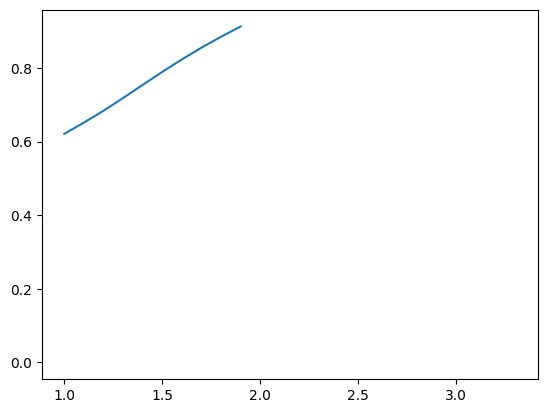

In [10]:
plt.plot(β1vec, Pvec)

In [17]:
index = 5
params = params_base.copy()
params['β1'] = β1vec[index]
N1_eq, N2_eq, F_eq, P_eq, mean_x_eq = get_equilibrium(params)

In [18]:
N1_eq

0.6640154536770038

In [19]:
from scipy.integrate import solve_ivp

t_f=2000  
initialstate = np.array([3, 0.5, 0.5, 3, *np.zeros(9)])
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))

In [20]:
T,N1,N2,P,Fxvec, mean_x = get_results(out2, 10)

In [21]:
check_at_equilibrium(Fxvec[:,-1], P[-1], N1[-1], N2[-1],**params)

(array([ 4.19799282e-05, -5.95186606e-11, -6.55303394e-11, -7.95778374e-12,
        -2.24320752e-13, -8.53093574e-14,  4.23135648e-05, -4.24518872e-05,
         1.42257767e-07, -2.29817123e-09]),
 0)

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='$T$, Scaled time'>)

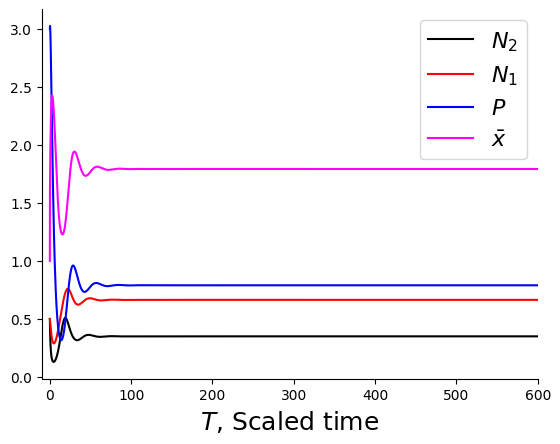

In [22]:
plot_all(T,N1,N2,P,mean_x)

In [31]:
eps

NameError: name 'eps' is not defined

In [26]:
N1_eq - N1[-1]

-2.3859557107819285e-08

In [28]:
N2_eq - N2[-1]

-1.7151951026139756e-08

In [30]:
mean_x_eq -mean_x[-1]

-8.39294164967086e-06

In [69]:
get_equilibrium(params, N1_0 = N1[-1], N2_0 = N2[-1], P_0 = P[-1], 
                F_of_x_vec = np.round(Fxvec[:,-1],8))

(nan, nan, nan, nan, nan)

In [71]:
N1_eq, N2_eq, F_eq, P_eq, mean_x_eq = get_equilibrium(params)

-0.11925967040687932
